# Topic Modeling Clustering

In this notebook we visualize a previously generated topic model.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_dbs()

['anphoblacht',
 'jstor_hyperparameter',
 'jstor_hyperparameter_demo',
 'okcupid',
 'tamilnet',
 'winereviews']

In [3]:
data_prefix = 'winereviews'
# data_prefix = 'jstor_hyperparameter'
# data_prefix = 'tamilnet'

In [4]:
# group_col = 'doc_points' # winereviews
group_col = 'doc_year' # jstor_hyperparameter
# group_col = 'doc_label' # tamilnet

In [5]:
db = tapi.Edition(data_prefix)

## Import Topic Data

We import our previously generated model.

In [6]:
db.get_tables()

LABELS
VOCAB
BOW
TOPICS
DTM
THETA
PHI
TOPICS_NMF
THETA_NMF
PHI_NMF


In [7]:
db.TOPICS_NMF[['topwords','doc_weight_sum']]

,topwords,doc_weight_sum
topic_id,,
0,"0 wine, fruits, ripe, rich, drink, tannins, wood",89.181919
1,"1 crisp, light, acidity, fresh, bright, wine, ...",65.148885
2,"2 lemon, lime, lemon lime, grapefruit, zest, r...",39.623773
3,"3 tannins, alongside, palate, aromas, cherry, ...",67.308991
4,"4 cabernet, sauvignon, cabernet sauvignon, ble...",44.589535
5,"5 red, red berry, red cherry, red fruit, red f...",40.488300
6,"6 berry, finish, plum, flavors, aromas, herbal...",70.376952
7,"7 black, black cherry, cherry, pepper, black p...",57.334993
8,"8 fruit, fruit flavors, flavors, tropical frui...",55.332295


# Inspect Results

## Sort Topics by Doc Weight

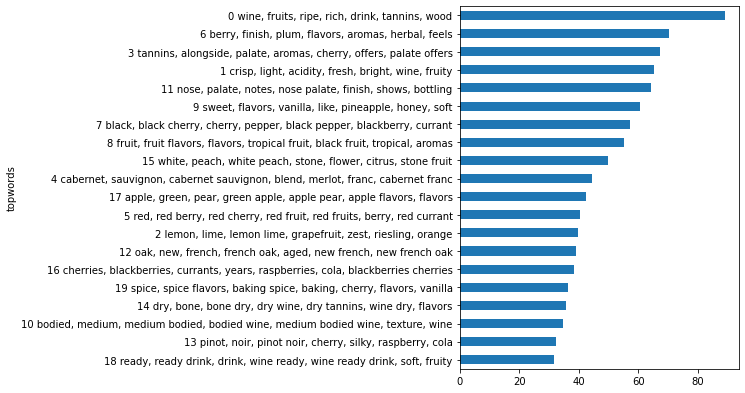

In [8]:
db.TOPICS_NMF.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, db.n_topics/3), legend=False);

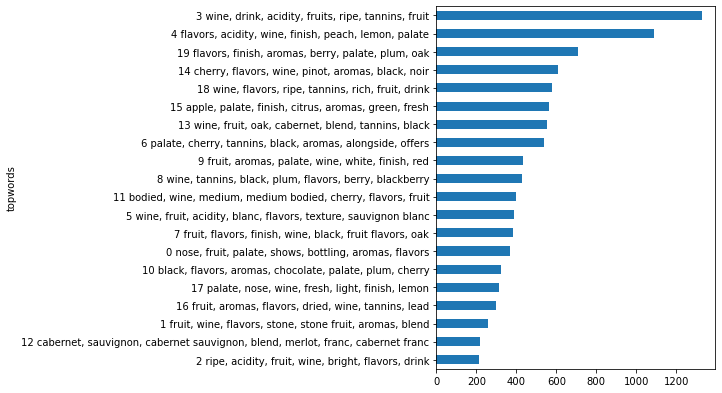

In [9]:
db.TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, db.n_topics/3), legend=False);

## Clutser Topics

In [10]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [11]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, db.n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [12]:
SIMS = pdist(normalize(db.PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

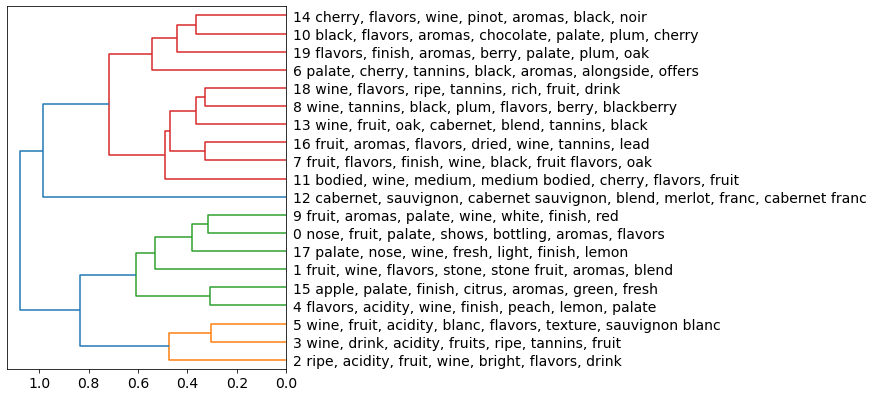

In [13]:
plot_tree(TREE, db.TOPICS.topwords.to_list());

In [14]:
SIMS = pdist(normalize(db.PHI_NMF), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

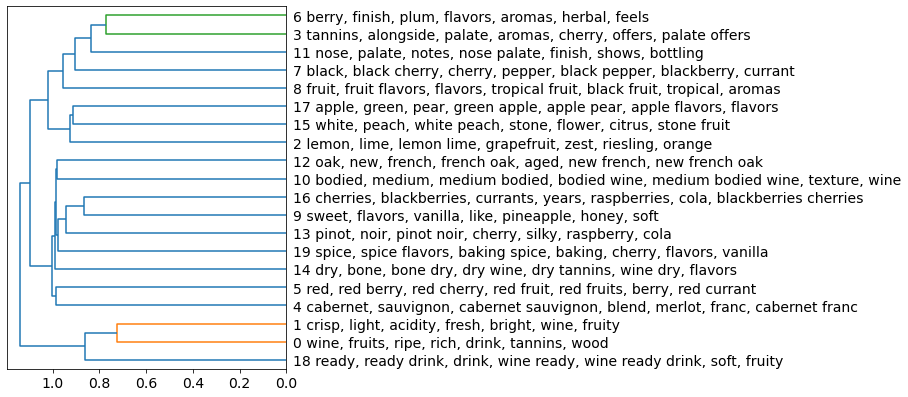

In [15]:
plot_tree(TREE, db.TOPICS_NMF.topwords.to_list());

## Group Topics by Label

In [16]:
db.LABELS.columns

Index(['doc_province', 'doc_label', 'doc_taster', 'doc_price', 'doc_variety',
       'doc_place', 'doc_title', 'doc_points'],
      dtype='object')

In [17]:
group_col

'doc_year'

In [18]:
group_vals = db.LABELS[group_col].value_counts().to_frame('n')
group_vals.index.name = 'group_id'

KeyError: 'doc_year'

In [ ]:
G = db.THETA.join(db.LABELS).groupby(group_col)[db.topic_cols].mean()
G.index.name = 'group_id'
G.columns = db.TOPICS.topwords

In [ ]:
G2 = db.THETA_NMF.join(db.LABELS).groupby(group_col)[db.topic_cols].mean()
G2.index.name = 'group_id'
G2.columns = db.TOPICS_NMF.topwords

### Heatmap of Labels and Topics

In [ ]:
G.style.background_gradient(cmap='YlGnBu', axis=0)

In [ ]:
G.style.background_gradient(cmap='YlGnBu', axis=1)

In [ ]:
G2.style.background_gradient(cmap='YlGnBu', axis=0)

In [ ]:
G2.style.background_gradient(cmap='YlGnBu', axis=1)

### Top Topic per Label Group

In [ ]:
group_vals['top_topic'] = G.T[group_vals.index].idxmax()
group_vals['top_topic2'] = G2.T[group_vals.index].idxmax()

In [ ]:
group_vals.sort_values('top_topic')

### Top Label Group per Topic

In [ ]:
G.idxmax().to_frame('label').sort_values('label')

In [ ]:
G2.idxmax().to_frame('label').sort_values('label')

## How Similar are the Topics to Each Other?

Get the dot product of the two topic series over documents.

In [ ]:
X = db.THETA.T.dot(db.THETA_NMF)
X.columns = db.TOPICS_NMF.topwords
X.index = db.TOPICS.topwords
X.columns.name = 'NMF'
X.index.name = 'LDA'

In [ ]:
# X

In [ ]:
X2 = X.stack().to_frame('w').sort_values('w', ascending=False)

In [ ]:
X2.head(10).style.bar()

## Frequency by Group

In [ ]:
group_vals.sort_index().plot.bar(rot=45, figsize=(15,5))